In [1]:
from OU_data import *

Generating surrogate Data with an OU_Process :

$$D = D_n + \delta D$$

with : $D_n(t)=c\exp(i\alpha(t))$ and $\delta D$ is a complex valued OU_process

Recall that a real OU_process is defined as $$\dot{x}= -\gamma x + \sigma \eta$$
with $\eta$ a gaussian white noise

In [2]:
#D_n : nominal direction
#data_dir : noisy direction (real direction)
data_dir, D_n = get_data()
delta_D = data_dir - D_n
dt = 200/len(data_dir)
n = 100 #kernel size
list_t = np.linspace(0,n*dt,n)
tau=0.5
lag = 1

Comparing with 3 models for simulated joystick data

Model 1 :
$$J = f \ast D$$
with : $f(t)=\frac{1}{\tau}\exp(-\frac{t}{\tau})\theta(t)$

Model 2 : 
$$J = f \ast D + \sigma\eta$$
with : $\eta$ following a complex valued OU process

Model 3 (introducing a lag T to model 1): 
$$J = g \ast D$$
with : $g(t)=\frac{1}{\tau}\exp(-\frac{t-T}{\tau})\theta(t-T)$


In [3]:
J1 = JS_1(data_dir) 
J2 = JS_2(data_dir) 
J3 = JS_3(data_dir)
#d_n_mat : nominal direction as a matrix
d_n_mat = D_n_matrix(D_n,n) #D_n[a:b]

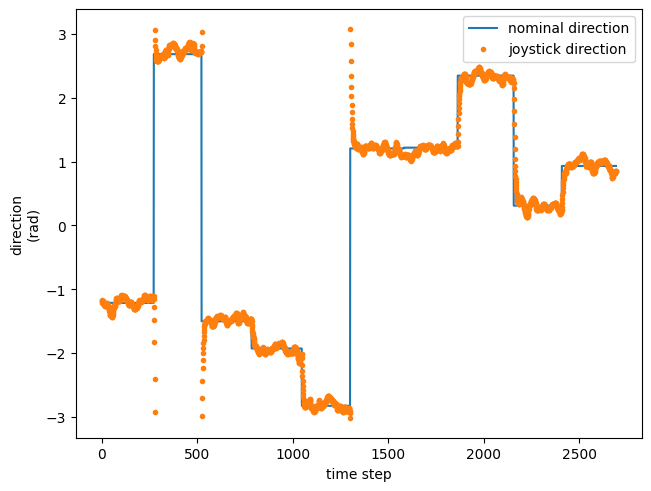

In [4]:
#plot J and direction in same fig
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(np.angle(D_n),label= 'nominal direction')
ax.plot(np.angle(J1),'.',label= 'joystick direction')
ax.legend()
ax.set_xlabel('time step')
ax.set_ylabel('direction\n(rad)')
plt.show()

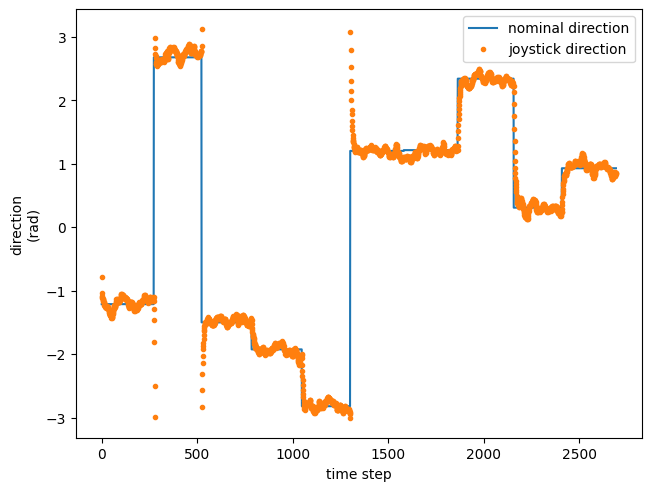

In [5]:
#plot J and direction in same fig
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(np.angle(D_n),label= 'nominal direction')
ax.plot(np.angle(J2),'.',label= 'joystick direction')
ax.legend()
ax.set_xlabel('time step')
ax.set_ylabel('direction\n(rad)')
plt.show()

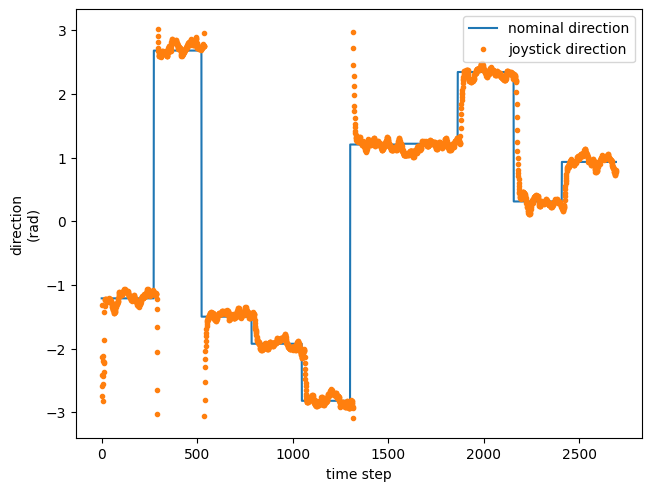

In [6]:
#plot J and direction in same fig
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(np.angle(D_n),label= 'nominal direction')
ax.plot(np.angle(J3),'.',label= 'joystick direction')
ax.legend()
ax.set_xlabel('time step')
ax.set_ylabel('direction\n(rad)')
plt.show()

Calculating the kernel (analytical solution)
$$Ker=\text{argmin}_K||J-K\ast D_n||^2$$
$$Ker = (M^{T}M)^{-1}M^{T}J$$
where $M_{\tau,t} = D_{n}(\tau-t)$ and $Ker^{T}=(K_{0}\cdots K_{m-1})$

In [7]:
ker1 = Ker_mat(d_n_mat,J1)
ker2 = Ker_mat(d_n_mat,J2)
ker3 = Ker_mat(d_n_mat,J3)
ker_th1 = np.exp(-list_t/tau)/tau
ker_th2 = np.exp(-list_t/tau)/tau
ker_th3 = np.exp(-(list_t-lag)/tau)/tau * np.heaviside(list_t-lag,0.5)

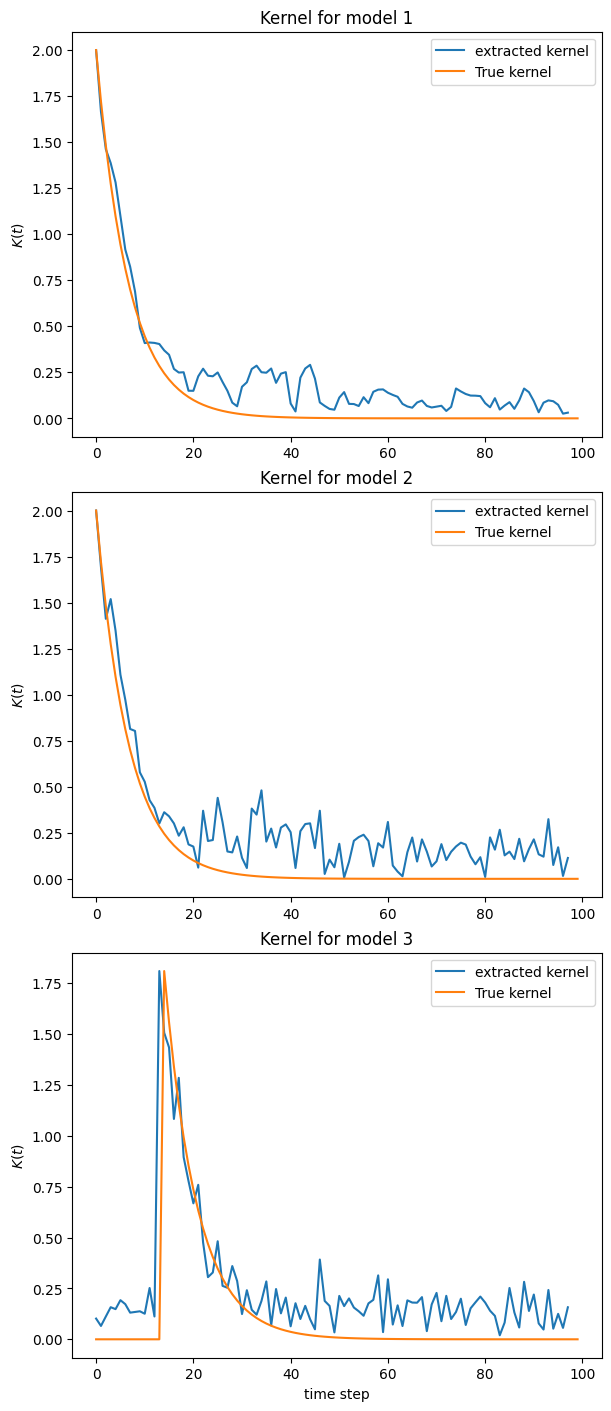

In [8]:
fig, ax = plt.subplots(3,constrained_layout=True,figsize=(6,14))
list_ratio = []
for (k,ker),ker_th in zip(enumerate([ker1,ker2,ker3]),[ker_th1,ker_th2,ker_th3]):
    ratio = np.max(np.abs(ker_th))/np.max(np.abs(ker[1:-1])) # multiplicative ratio that doesn't affect the characteristic time
    list_ratio.append(ratio)
    ax[k].plot(np.abs(ker[1:-1]*ratio),label='extracted kernel')
    ax[k].plot(np.abs(ker_th),label='True kernel')
    ax[k].set_title('Kernel for model '+str(k+1))
    ax[k].set_ylabel(r'$K(t)$')
    ax[k].legend()
ax[k].set_xlabel('time step')
plt.show()

Calculating the denoised joystic direction with the kernel calculated above 
$$J^{p}= Ker\ast D_n$$

In [9]:
J_p1 = np.convolve(list_ratio[0]*ker1,D_n,mode='same')*dt
J_p2 = np.convolve(list_ratio[1]*ker2,D_n,mode='same')*dt
J_p3 = np.convolve(list_ratio[2]*ker3,D_n,mode='same')*dt

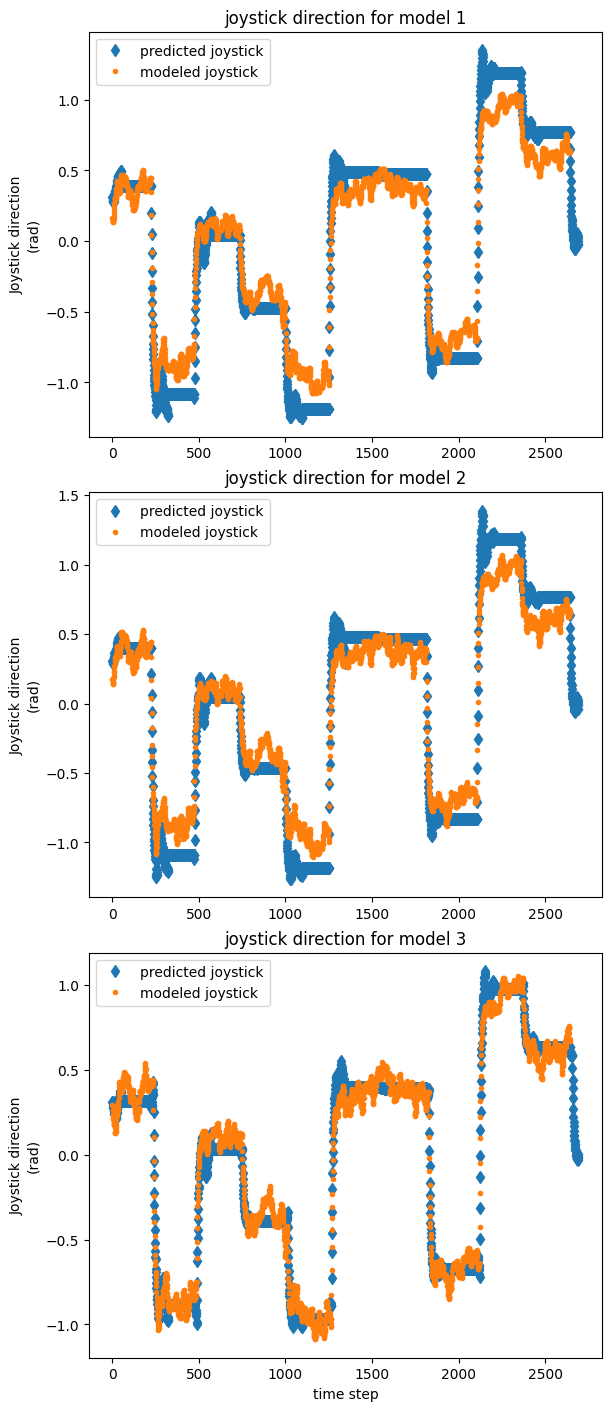

In [10]:
fig, ax = plt.subplots(3,constrained_layout=True,figsize=(6,14))
for (k,J_p),J in zip(enumerate([J_p1,J_p2,J_p3]),[J1,J2,J3]):
    ax[k].plot(np.real(J_p),'d',label='predicted joystick')
    ax[k].plot(np.real(J)[50:],'.',label='modeled joystick')
    ax[k].set_title('joystick direction for model '+str(k+1))
    ax[k].set_ylabel('Joystick direction\n(rad)')
    ax[k].legend()
ax[k].set_xlabel('time step')
plt.show()

separating deterministic from stochastic part:
$$\delta J = J - J^{p}$$

In [11]:
dJ1 = J1 - J_p1
dJ2 = J2 - J_p2
dJ3 = J3 - J_p3

computing the cross correlation between $\delta J$ and $\delta D$
$$ C_{D,J}(\tau) =  \int_{-\infty}^{\infty} \delta D(t)\delta J(\tau + t)dt$$

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


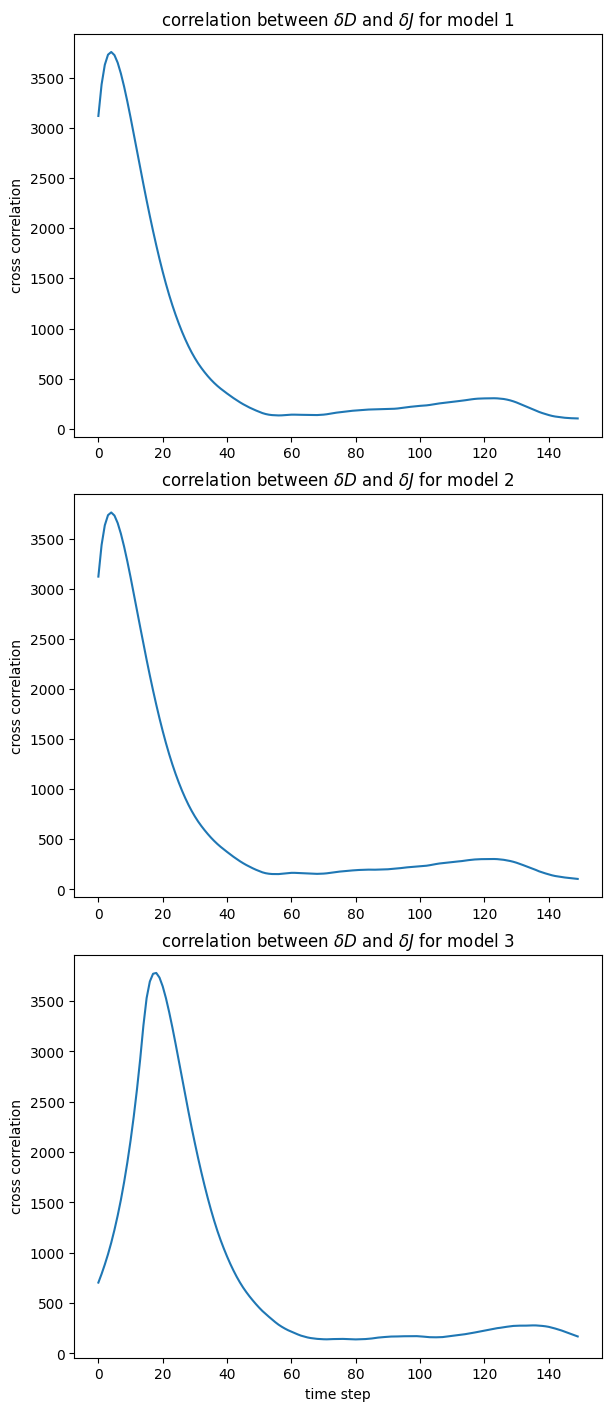

In [12]:
C1,C2,C3 = all_to_ker()
nb_avg = 100
for i in range(nb_avg):
    d1, d2, d3 = all_to_ker()
    nb = min(len(C1),len(d1))
    C1[:nb] += d1[:nb]
    C2[:nb] += d2[:nb]
    C3[:nb] += d3[:nb]
    #to have a smoother result we can average
    if not i%(nb_avg//10):
        print(100*i/nb_avg,"%")

fig, ax = plt.subplots(3,constrained_layout=True,figsize=(6,14))
for k,C in enumerate([C1,C2,C3]):
    ax[k].plot(np.abs(C)[:150])
    ax[k].set_title(r'correlation between $\delta D$ and $\delta J$ for model '+str(k+1))
    ax[k].set_ylabel('cross correlation')
ax[k].set_xlabel('time step')
plt.show()